In [43]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




#### Loading Data:

In [34]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\joined_trend_sales_All1_copy.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y-%m-%d")
df = df.sort_values("Periode").reset_index(drop=True)



In [16]:
df = df.rename(columns={
"Bijtelling (%)": "Company car tax rate (%)"

})

In [35]:
print(df.columns.tolist())

['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen']


##### Time
- **Period** — (T)  
  *(Month/Year of observation)*

##### Google Search Terms (G)
- **Home charging (G)**
- **Electric car (G)**
- **Hybrid electric (G)**

##### Consumer Confidence Indicators (E)
- **Consumer confidence (E)**
- **Economic climate perception (E)**
- **Willingness to buy (E)**
- **Major purchases sentiment (E)**

##### Fuel Prices (F)
- **Gasoline (Euro95) - First price (F)**
- **Gasoline (Euro95) - Last price (F)**
- **Gasoline (Euro95) - Minimum price (F)**
- **Gasoline (Euro95) - Maximum price (F)**
- **Gasoline (Euro95) - Average price (F)**
- **Diesel - First price (F)**
- **Diesel - Last price (F)**
- **Diesel - Minimum price (F)**
- **Diesel - Maximum price (F)**
- **Diesel - Average price (F)**

##### Fiscal Incentives (P)
- **Company car tax rate (%) (P)**

##### Target Variable
- **Total vehicles sold (Target)**

---

##### Legend
- **(T)** = Time  
- **(G)** = Google Trends (behavioral signals)  
- **(E)** = Economic sentiment (CBS)  
- **(F)** = Fuel prices (CBS)  
- **(P)** = Policy/fiscal variables  
- **(Target)** = Dependent variable


In [36]:



df = df.rename(columns={
    "Periode": "Time Period (T)",
    "thuis opladen": "Home charging (G)",
    "elektrische auto": "Electric car (G)",
    "hybride elektrisch": "Hybrid electric (G)",
    "Consumentenvertrouwen": "Consumer confidence (E)",
    "Economisch klimaat": "Economic climate perception (E)",
    "Koopbereidheid": "Willingness to buy (E)",
    "Grote aankopen": "Major purchases sentiment (E)",
    "BenzineEuro95_1_first": "Gasoline (Euro95) - First price (F)",
    "BenzineEuro95_1_last": "Gasoline (Euro95) - Last price (F)",
    "BenzineEuro95_1_min": "Gasoline (Euro95) - Minimum price (F)",
    "BenzineEuro95_1_max": "Gasoline (Euro95) - Maximum price (F)",
    "BenzineEuro95_1_mean": "Gasoline (Euro95) - Average price (F)",
    "Diesel_2_first": "Diesel - First price (F)",
    "Diesel_2_last": "Diesel - Last price (F)",
    "Diesel_2_min": "Diesel - Minimum price (F)",
    "Diesel_2_max": "Diesel - Maximum price (F)",
    "Diesel_2_mean": "Diesel - Average price (F)",
    "Bijtelling (%)": "Company car tax rate (%)",
    "Totaal_verkochte_wegvoertuigen": "Total vehicles sold (Target)"
})

In [37]:
print(df.columns.tolist())

['Time Period (T)', 'Home charging (G)', 'Electric car (G)', 'Hybrid electric (G)', 'Company car tax rate (%)', 'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)', 'Major purchases sentiment (E)', 'Gasoline (Euro95) - First price (F)', 'Gasoline (Euro95) - Last price (F)', 'Gasoline (Euro95) - Minimum price (F)', 'Gasoline (Euro95) - Maximum price (F)', 'Gasoline (Euro95) - Average price (F)', 'Diesel - First price (F)', 'Diesel - Last price (F)', 'Diesel - Minimum price (F)', 'Diesel - Maximum price (F)', 'Diesel - Average price (F)', 'Total vehicles sold (Target)']


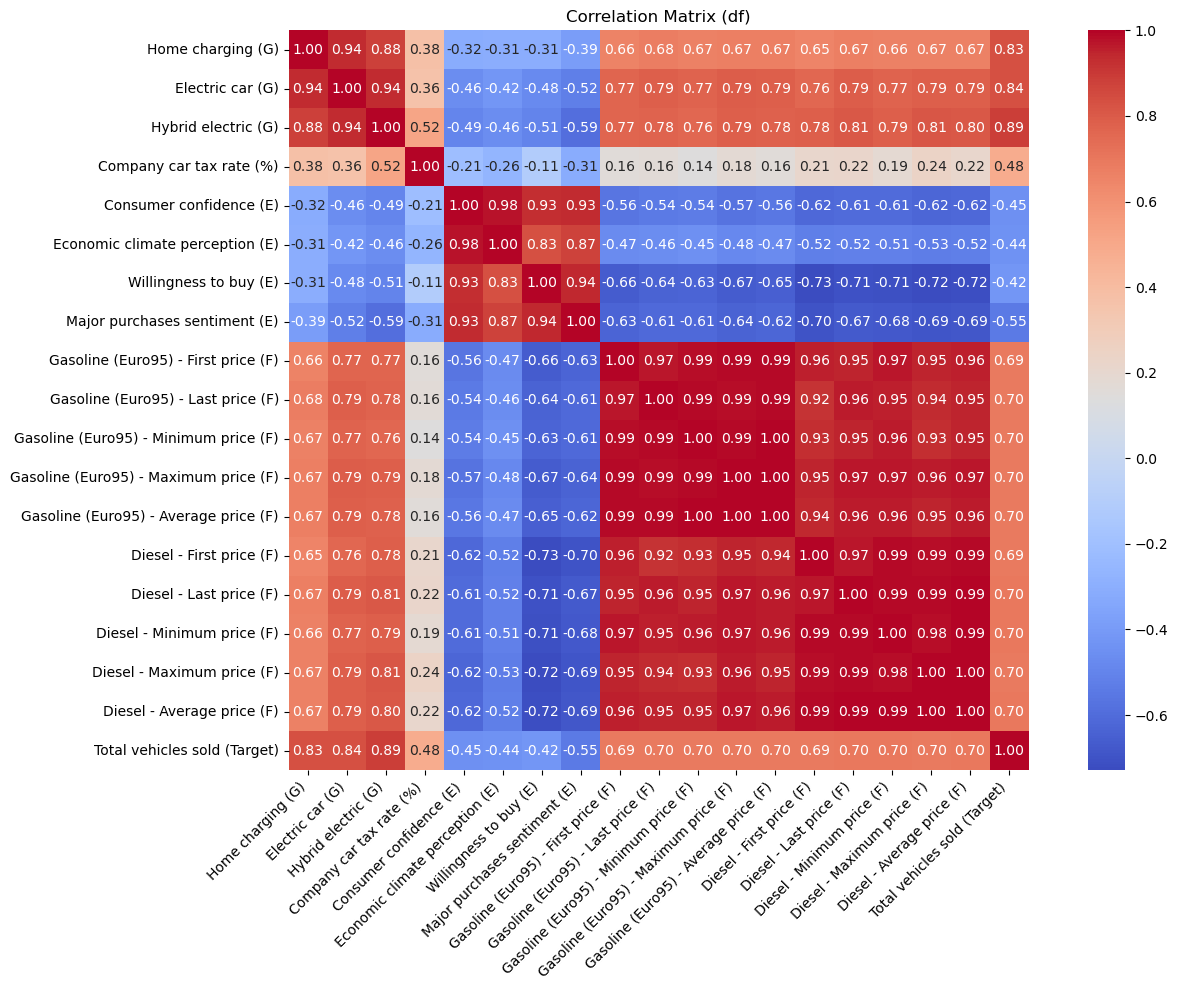

In [42]:

# Compute correlation matrix for df
corr_matrix = df.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


> becaase there is still some multicorniality, we will drop the first and last price of gasoline and diesel, as well as the minimum and maximum prices, to keep only the average price for each fuel type.

In [38]:
# Drop specified columns from df and save to CSV
cols_to_remove = [
    'Gasoline (Euro95) - First price (F)', 'Gasoline (Euro95) - Last price (F)',
    'Gasoline (Euro95) - Minimum price (F)', 'Gasoline (Euro95) - Maximum price (F)',
    'Diesel - First price (F)', 'Diesel - Last price (F)',
    'Diesel - Minimum price (F)', 'Diesel - Maximum price (F)'
]
df_avg = df.drop(columns=cols_to_remove).copy()
df_avg.to_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv", index=False)

In [39]:
display(df_avg)


,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.00,37.0,9.00,8.00,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.00,37.0,9.00,8.00,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.00,37.0,9.00,8.00,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.00,37.0,9.00,8.00,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.00,32.0,9.00,7.40,1.466516,1.032323,84
...,...,...,...,...,...,...,...,...,...,...,...,...
212,2024-09-01,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.879633,1.607667,28820
213,2024-10-01,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.902806,1.640419,30491
214,2024-11-01,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.947800,1.716167,32623
215,2024-12-01,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.947871,1.725774,39594


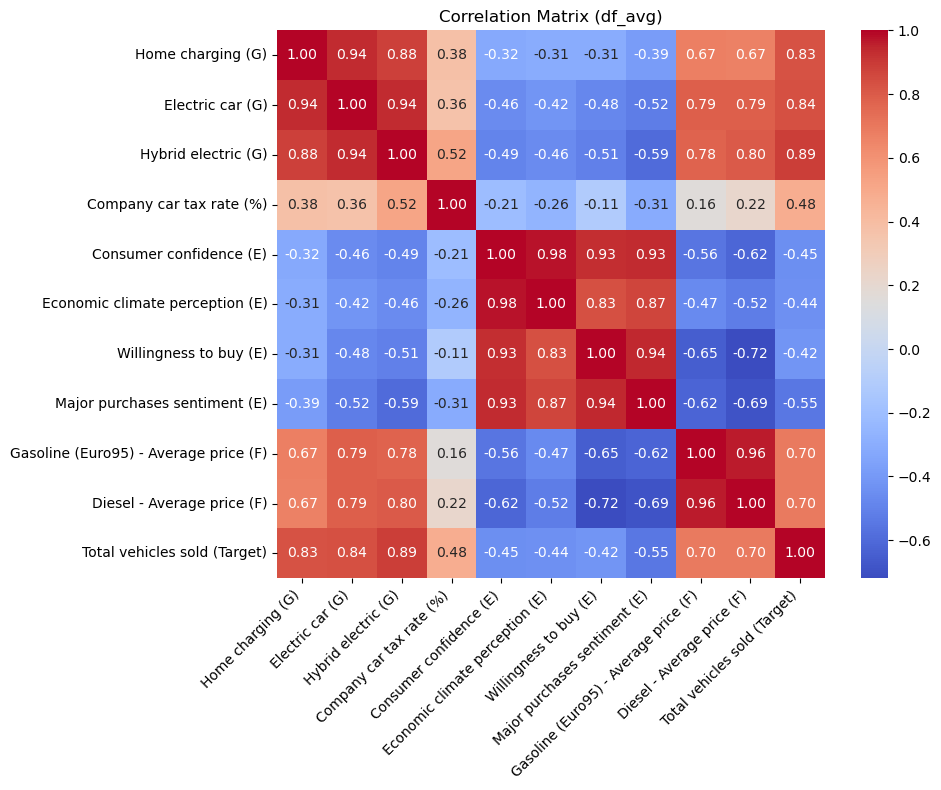

In [40]:
# Compute correlation matrix for df_avg
corr_matrix_avg = df_avg.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_avg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df_avg)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

becaase there is still some multicorniality, we will drop the first and last price of gasoline and diesel, as well as the minimum and maximum prices, to keep only the average price for each fuel type.


,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.644864,0.644864
1,PC2,0.185629,0.830493
2,PC3,0.091281,0.921774
3,PC4,0.035570,0.957344
4,PC5,0.016419,0.973763
5,PC6,0.012618,0.986381
6,PC7,0.005808,0.992189
7,PC8,0.003299,0.995488
8,PC9,0.002990,0.998479
9,PC10,0.001513,0.999991


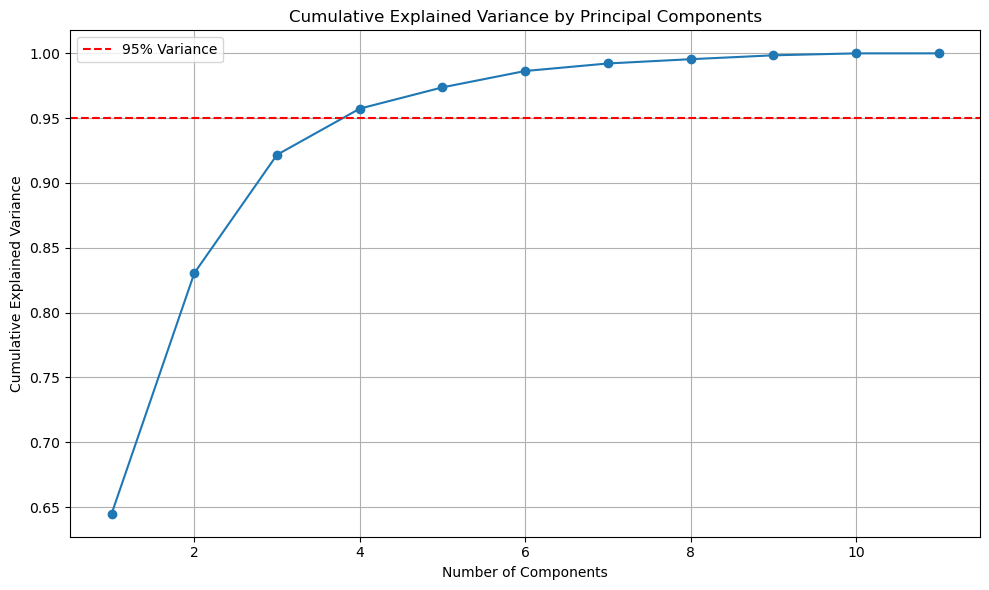

In [46]:

# Select only numeric columns (excluding the target and datetime columns)
features = [col for col in df_avg.columns if col not in ['Totaal_verkochte_wegvoertuigen', 'Time Period (T)']]
X = df_avg[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for explained variance
explained_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca.explained_variance_ratio_)
})

display(explained_variance)

# Plot Scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

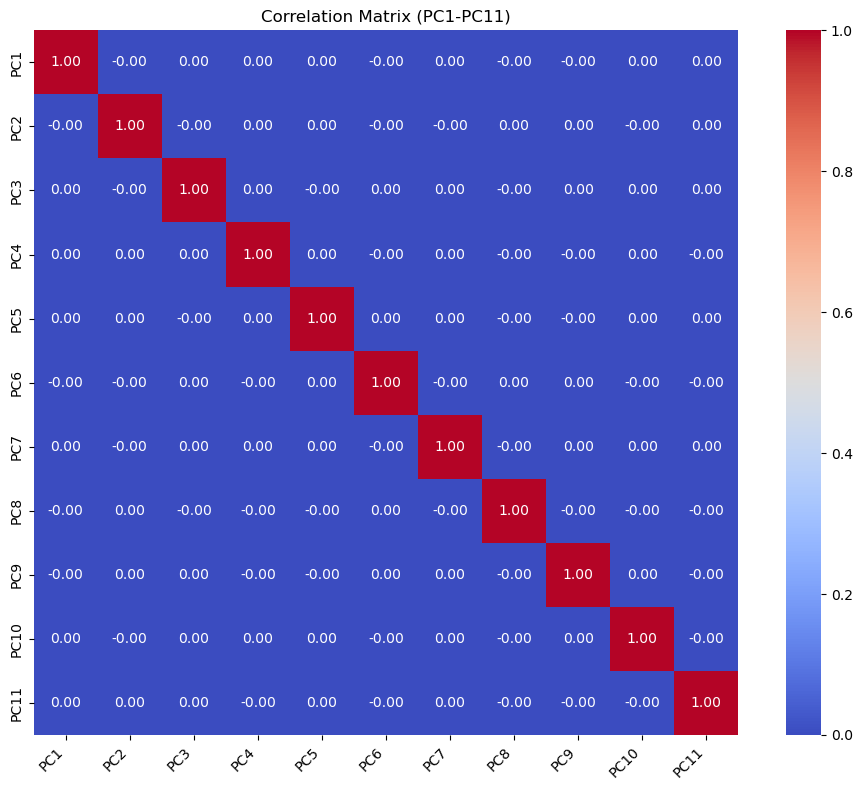

In [57]:
# Plot correlation matrix for the first 11 principal components
pc_df = pd.DataFrame(X_pca[:, :11], columns=[f'PC{i+1}' for i in range(11)])
corr_matrix_pcs = pc_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pcs, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (PC1-PC11)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [50]:
# Get PCA components (loadings)
loadings = pd.DataFrame(
    pca.components_[:3],  # PC1, PC2, PC3
    columns=X.columns,
    index=['PC1', 'PC2', 'PC3']
)

# Compute combined influence: sum of absolute loadings for PC1-PC3
combined_influence = loadings.abs().sum(axis=0).sort_values(ascending=False)

# Top 5 variables
top5 = combined_influence.head(5)
print("Top 5 variables (PC1-PC3 combined influence):")
print(top5)

Top 5 variables (PC1-PC3 combined influence):
Company car tax rate (%)                 1.164071
Economic climate perception (E)          0.876384
Consumer confidence (E)                  0.801296
Willingness to buy (E)                   0.790610
Gasoline (Euro95) - Average price (F)    0.785076
dtype: float64


In [55]:
df_top5_period.to_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\PCA.csv", index=False)


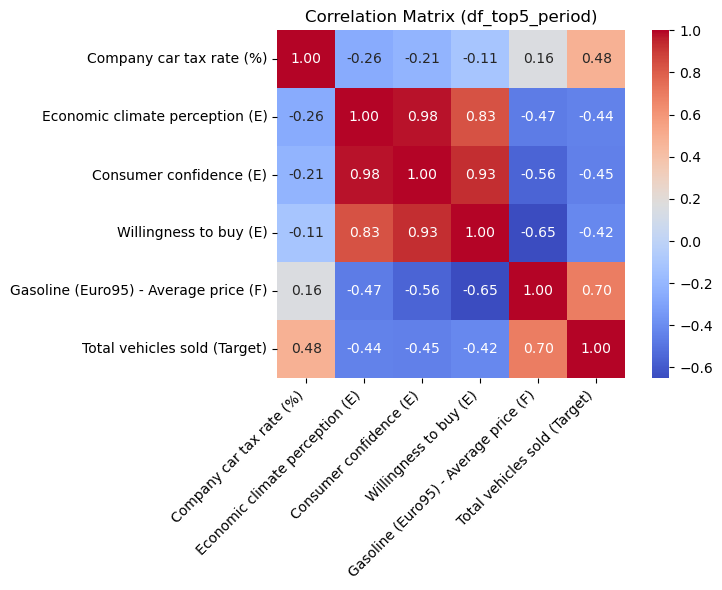

In [56]:
# Compute correlation matrix for df_top5_period (excluding the datetime column)
corr_matrix_top5 = df_top5_period.drop(columns=['Time Period (T)']).corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_top5, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df_top5_period)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [54]:
# Create a new DataFrame with only the top 5 variables (plus the target if needed)
top5_vars = top5.index.tolist()
df_top5 = df_avg[top5_vars + ['Total vehicles sold (Target)']]
display(df_top5.head())

,Company car tax rate (%),Economic climate perception (E),Consumer confidence (E),Willingness to buy (E),Gasoline (Euro95) - Average price (F),Total vehicles sold (Target)
0,22,37.0,20.0,9.0,1.303032,31
1,22,37.0,20.0,9.0,1.325357,39
2,22,37.0,20.0,9.0,1.379032,123
3,22,37.0,20.0,9.0,1.426500,62
4,22,32.0,18.0,9.0,1.466516,84
